<a href="https://colab.research.google.com/github/w4bo/AA2324-unibo-bigdataandcloudplatforms/blob/main/notebooks/01-CaliforniaHousingPricing_v0_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California housing pricing

This notebook runs on Google Colab. Colab provides a serverless Jupyter notebook environment for interactive development. (At the moment, 2022) Google Colab is free to use like other G Suite products.

In this laboratory we will build a simple data pipeline to get acquainted with the "main" steps necessary to transform your data.

The data contains information from the 1990 California census. It does provide an accessible introductory dataset for teaching people about the basics of machine learning. For simplcity, we will import the data from a csv file. Check also: https://www.kaggle.com/camnugent/california-housing-prices

From https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

    This data has metrics such as the population, median income, median housing price, and so on for each block group in California.
    Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short
    The goal is to build a model to predict the median housing price in any district, given all the other metrics

In case you need help with preprocessing with Pandas, check:

    https://github.com/w4bo/2022-bbs-dm/blob/main/notebooks/01-PandasFundaments.ipynb



First of all, we need to setup the Python environment by installing and importing the necessary Python dependencies.

In [1]:
!pip install prov pydot
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import prov

print(pd.__version__)
print(sk.__version__)
print(np.__version__)
print(sns.__version__)
print(prov.__version__)

2.1.2
1.3.0
1.26.0
0.12.2
2.0.0


#### Data collection

Import the dataset. In this case, there is no need for ETL/integration since the dataset is ready for elaboration.

In [3]:
df = pd.read_csv("https://w4bo.github.io/AA2324-unibo-bigdataandcloudplatforms/housing.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


#### Data understanding

Dataset description

1. `longitude`: A measure of how far west a house is; a higher value is farther west
2. `latitude`: A measure of how far north a house is; a higher value is farther north
3. `housingMedianAge`: Median age of a house within a block; a lower number is a newer building
4. `totalRooms`: Total number of rooms within a block
5. `totalBedrooms`: Total number of bedrooms within a block
6. `population`: Total number of people residing within a block
7. `households`: Total number of households, a group of people residing within a home unit, for a block
8. `medianIncome`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. `medianHouseValue`: Median house value for households within a block (measured in US Dollars)
10. `oceanProximity`: Location of the house w.r.t ocean/sea

Let's take a look at the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


#### Memory usage

What if I change float64 to float32?

In [7]:
dff = df.copy(deep=True) # copy the dataframe
for x in df.columns: # iterate over the columns
    if dff[x].dtype == 'float64': # if the column has type `float64`
        dff[x] = dff[x].astype('float32') # ... change it to `float32`
dff.info() # show some statistics on the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   median_house_value  20640 non-null  float32
 9   ocean_proximity     20640 non-null  object 
dtypes: float32(9), object(1)
memory usage: 887.0+ KB


There are some missing values in the column `total_bedorooms` what can we do?

Most Machine Learning algorithms cannot work with missing features. We have three options:

Get rid of the corresponding districts (i.e., drop the rows)

    df.dropna(subset=["total_bedrooms"])

Get rid of the whole attribute (i.e., drop the columns)

    df.drop("total_bedrooms", axis=1)

Set the values to some value (zero, the mean, the median, etc.)

    df["total_bedrooms"].fillna(df["total_bedrooms"].median())

#### Non-numeric attributes

`ocean_proximity` is a text attribute so we cannot compute its median. Some options:
- Get rid of the whole attribute. (`df.drop("ocean_proximity", axis=1`)
- Change from categorical to ordinal (e.g., `NEAR BAY` = 0, `INLAND` = 1)
    - Can foresee any problem in this?
    - ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). 
- Change from categorical to one hot encoding
    - To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes

In [8]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<Axes: >

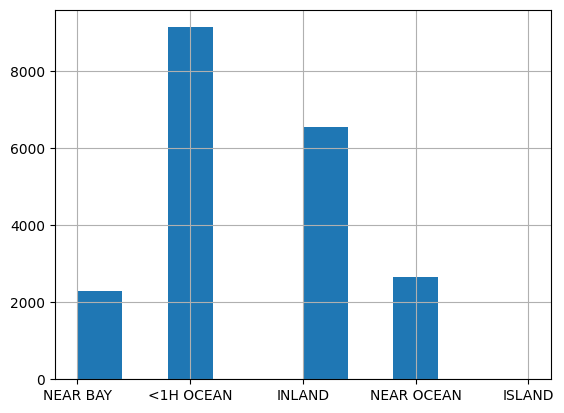

In [9]:
df["ocean_proximity"].hist()

Change from categorical to ordinal

In [10]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
y = ordinal_encoder.fit_transform(df[["ocean_proximity"]])
y

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

From categorical to one-hot encoding

In [11]:
y = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')
y

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,True,False
...,...,...,...,...,...
20635,False,True,False,False,False
20636,False,True,False,False,False
20637,False,True,False,False,False
20638,False,True,False,False,False


#### Visualization

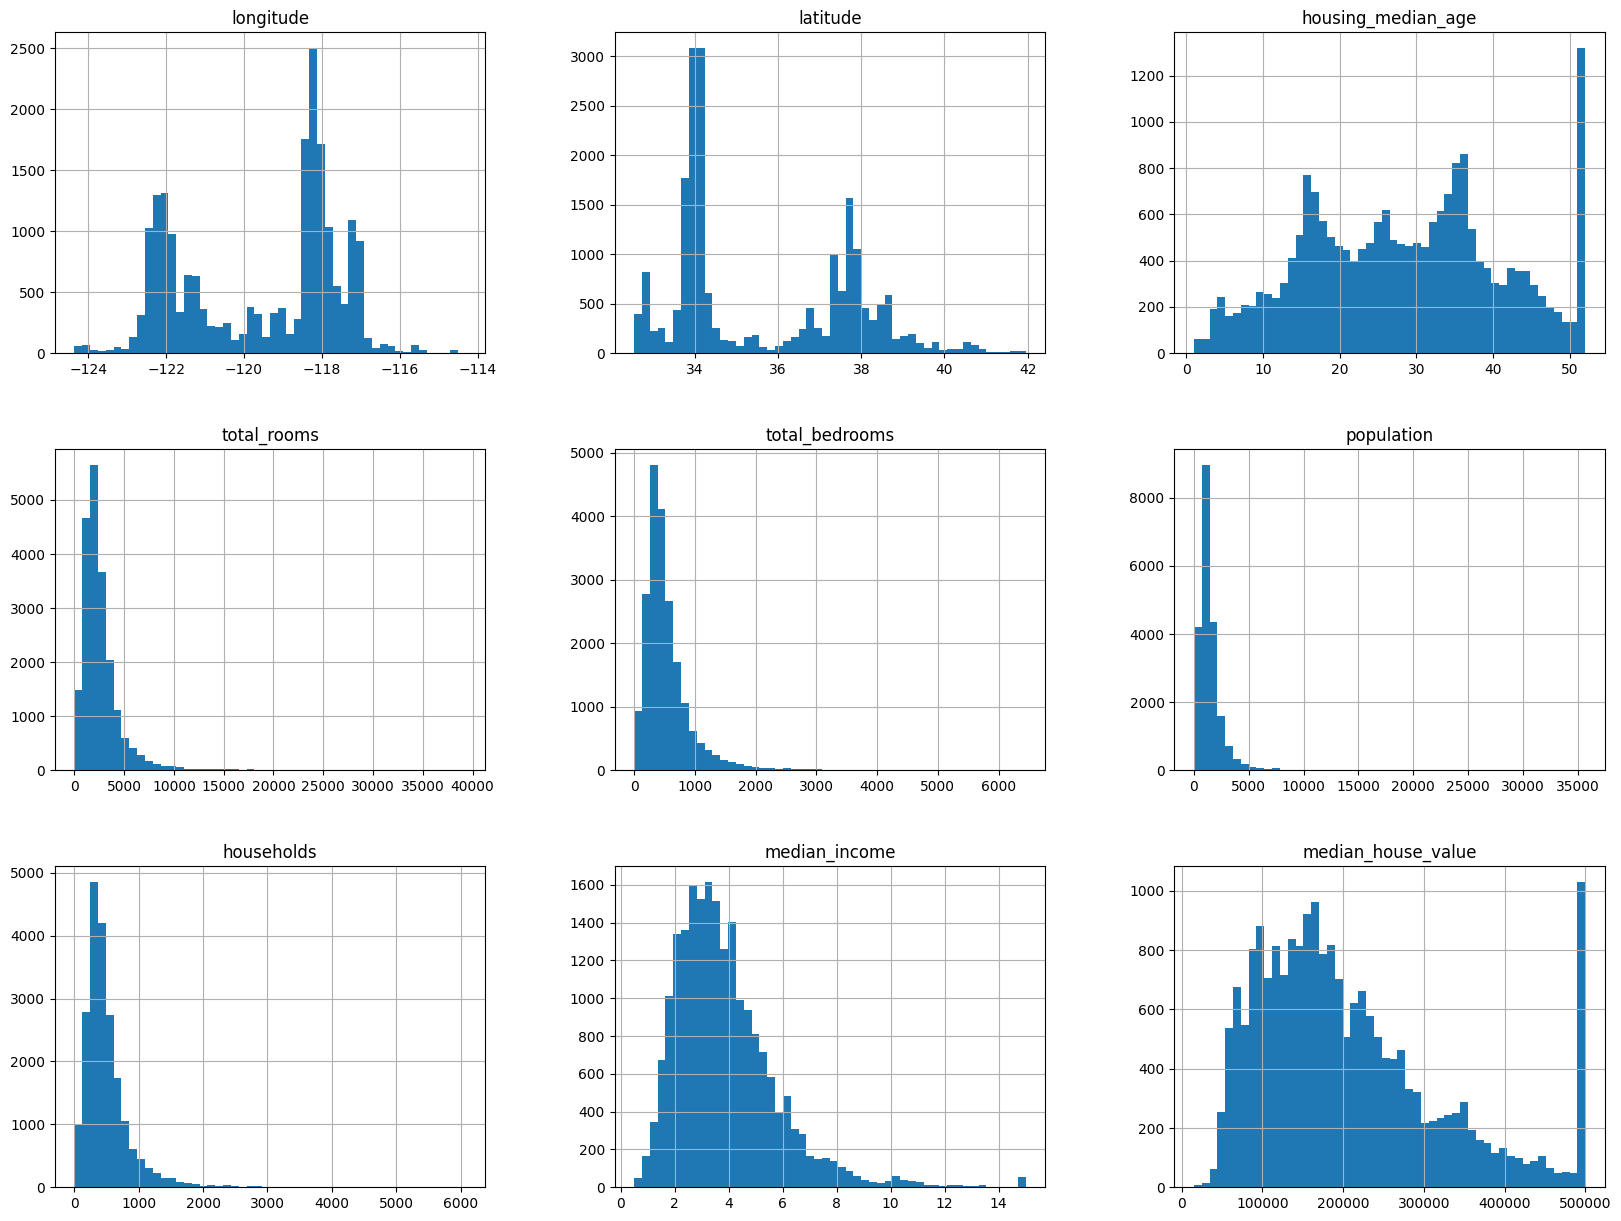

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

Open questions:

- `median_income` should be in dollars. However, it has a strange range. Why? "you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars. The numbers represent roughly tens of thousands of dollars"
- `housing_median_age` and `median_house_value` are capped. As to `median_house_value`, this is a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000USD, then you have mainly two options: (a) collect proper labels for the districts whose labels were capped, (b) remove those districts from the training set."
- These attributes have very different scales. Should we scale them?
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns

##### Are there relationships between variables?

Create a grid of Axes such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column.

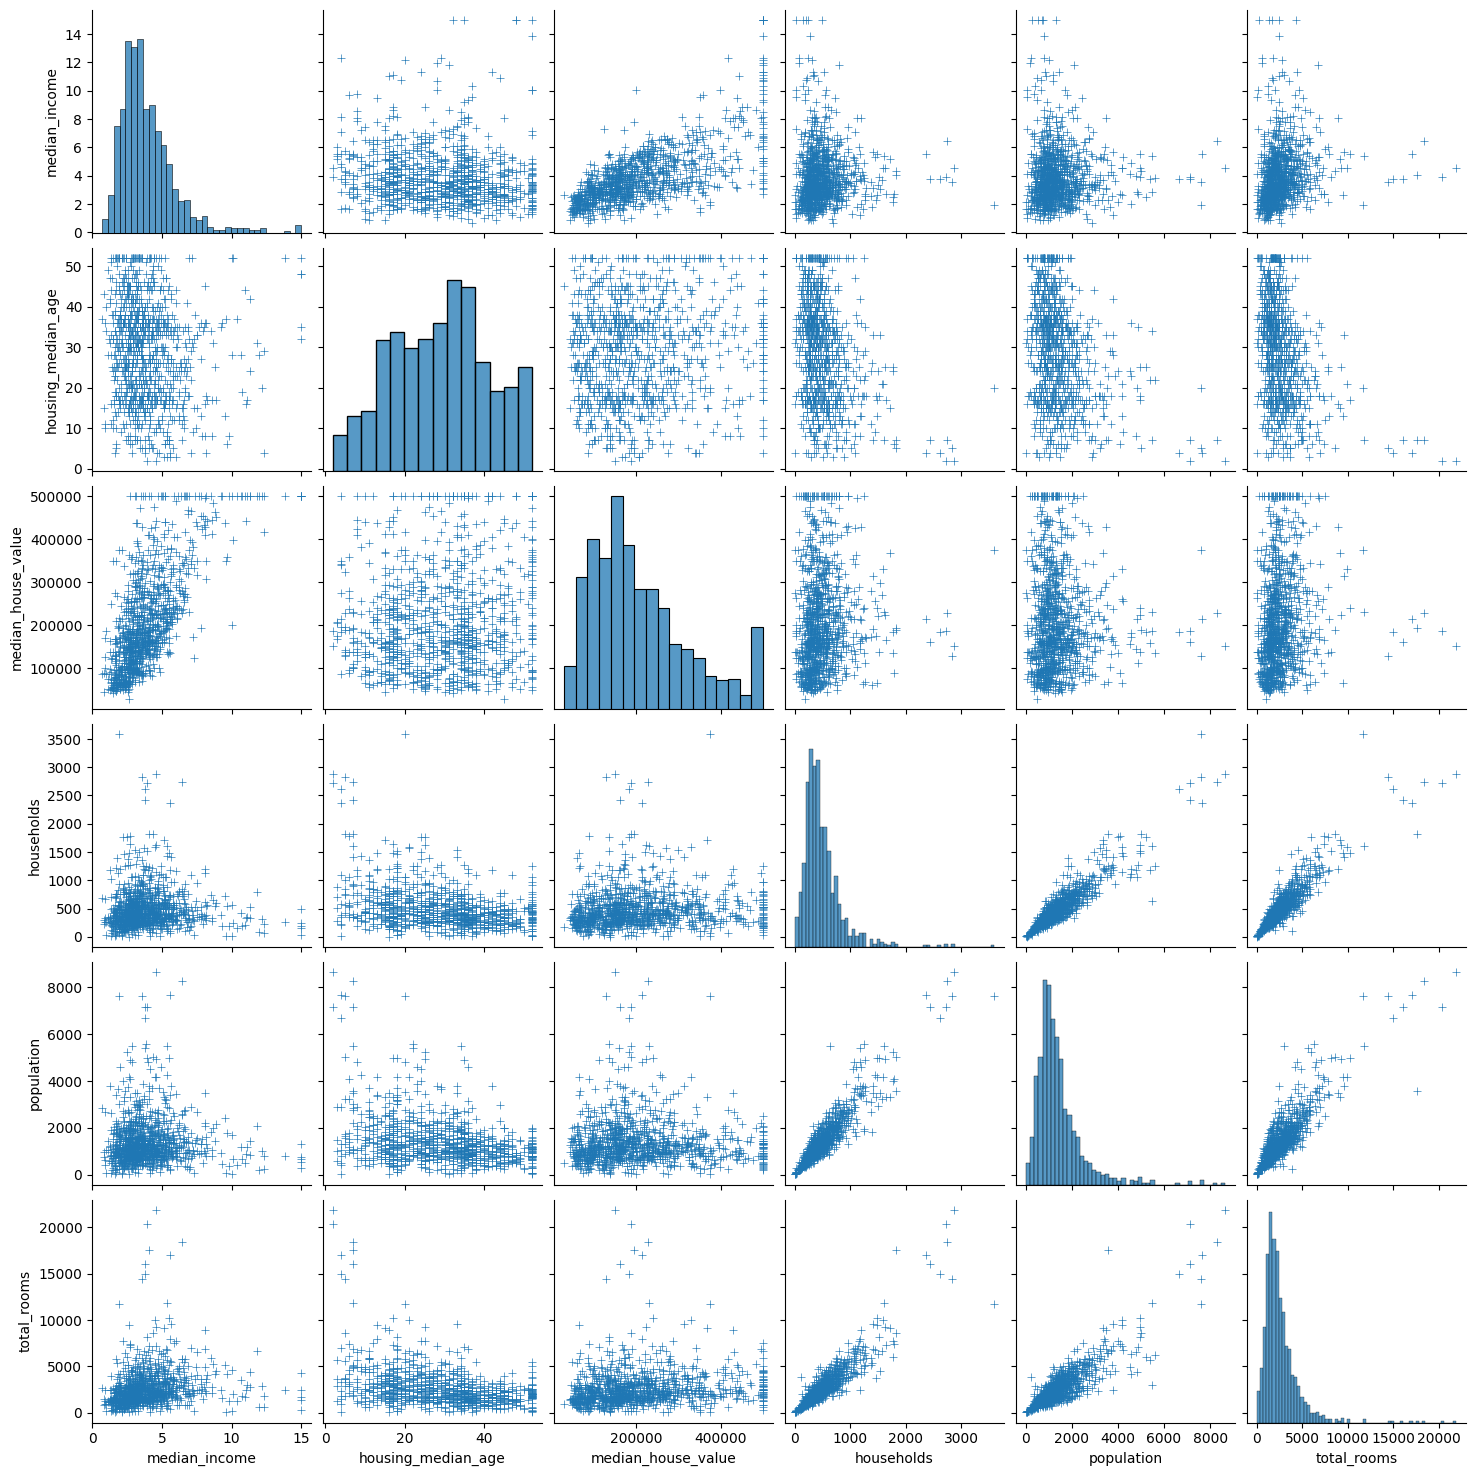

In [13]:
tmp = df[["median_income", "housing_median_age", "median_house_value", "households", "population", "total_rooms"]]
# sns.pairplot(tmp.sample(n=1000, random_state=42), hue="median_house_value", markers='+')
sns.pairplot(tmp.sample(n=1000, random_state=42), markers='+')
plt.show()

#### Scaling attributes

Attributes have very different scales. Should we scale them?

- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
- Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.


##### Min-max normalization

In [14]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.min()) / (num_df.max() - num_df.min())
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776
...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295


##### Standardization

In [15]:
num_df = df.drop(columns=['ocean_proximity', 'median_house_value'])
normalized_df = (num_df - num_df.mean()) / num_df.std()
normalized_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881
...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388886,-0.512579,-0.443438,-1.216099
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.920466,-0.944382,-1.008396,-0.691576
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125468,-0.369528,-0.174037,-1.142566
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305826,-0.604415,-0.393743,-1.054557


#### Machine learning

In [16]:
# For now we simply drop "ocean_proximity"
if "ocean_proximity" in df.columns:
  df = df.drop("ocean_proximity", axis=1)

# Let's create some dataset variation
# dataset1: drop the rows containing the null values and the columns `latitude` and `longitude` 
dataset_v1 = df.copy(deep=True).dropna().drop(["longitude", "latitude"], axis=1)

# dataset2: impute missing values with the average number of bedrooms 
dataset_v2 = df.copy(deep=True)
dataset_v2["total_bedrooms"] = dataset_v2["total_bedrooms"].fillna(dataset_v2["total_bedrooms"].mean())

# Create the list of datasets
datasets = [(dataset_v1, "datasetv1"), (dataset_v2, "datasetv2")]

In [17]:
# Let's import some machine learning models (here we are not addressing hyper-parameter tuning)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

dt = DecisionTreeRegressor(random_state=0) # initialize decision tree regressor model
lr = LinearRegression() # initialize a linear regressor model

# Create the list of algorithms
ml_algorithms = [(lr, "lr"), (dt, "dt")]

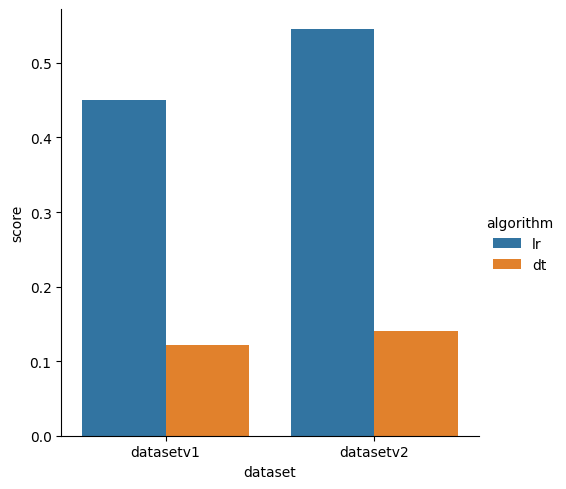

In [18]:
from sklearn.model_selection import cross_val_score

instances = []
i = 0

# For each dataset version...
for dataset, dataset_version in datasets:
  # Get the feature matrix
  X = dataset.drop(columns=["median_house_value"]).to_numpy()
  # Get the train label array
  y = dataset["median_house_value"].to_numpy() 
  
  # For each machine learning algorithm...
  for ml_algorithm, ml_algorithm_version in ml_algorithms:
    # Run the machine learning algorithm on the given dataset
    # Each run is a pipeline instance that we shoul compare against the others
    instance = {}
    instance["id"] = i  # store the id of the instance 
    instance["dataset"] = dataset_version  # store the version of the dataset
    instance["algorithm"] = ml_algorithm_version  # store the version of the ml algorithm
    instance["score"] = cross_val_score(ml_algorithm, X, y, cv=10).mean()  # store the performance of the pipeline instance
    instances = instances + [instance]
    i += 1

# Collect the results
result = pd.DataFrame.from_dict(instances, orient='columns')
sns.catplot(x = "dataset", y = "score", hue = "algorithm", data = result, kind = "bar")

And what about data provenance?

In [19]:
!apt update -y
!apt install graphviz -y

Hit:1 http://deb.debian.org/debian bullseye InRelease
Hit:2 http://deb.debian.org/debian-security bullseye-security InRelease
Hit:3 http://deb.debian.org/debian bullseye-updates InRelease
Reading package lists... Done3m
Building dependency tree... Done
Reading state information... Done
2 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-5).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


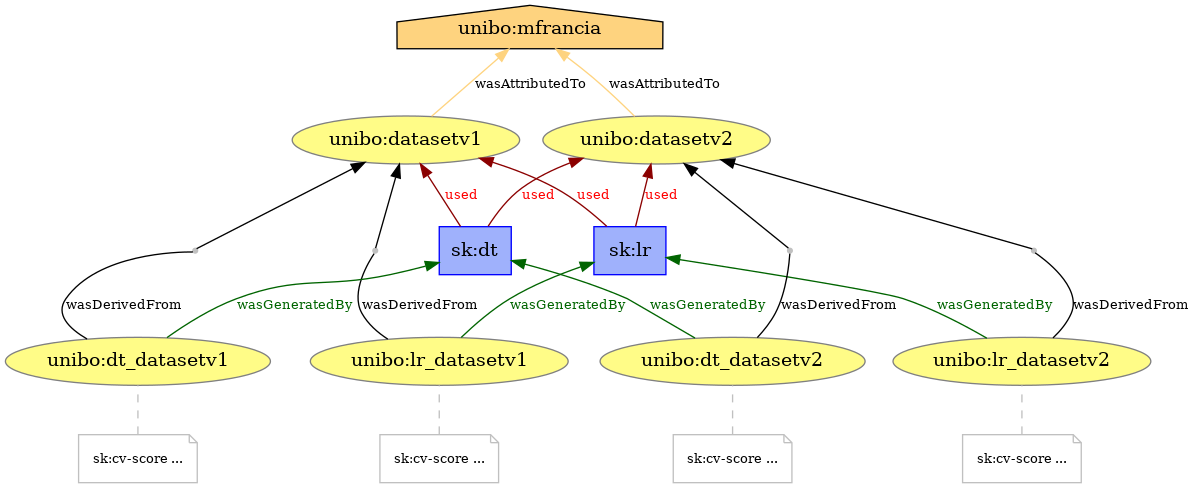

In [20]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image

# Create a new provenance document
d1 = ProvDocument()  # d1 is now an empty provenance document
d1.add_namespace('unibo', 'https://www.unibo.it')  # add the namespace
d1.add_namespace('sk', 'https://scikit-learn.org/stable/')  # add the namespace
agent = d1.agent('unibo:mfrancia')  # add an agent

# For each dataset version...
for dataset, dataset_version in datasets:
  original_dataset = d1.entity('unibo:' + dataset_version)  # register the dataset
  d1.wasAttributedTo(original_dataset, agent)  # attribute the dataset to the agent who created it
  # For each machine learning algorithm...
  for ml_algorithm, ml_algorithm_version in ml_algorithms:
    algo = d1.activity('sk:' + ml_algorithm_version)  # register the algorithm as a (processing) activity
    processed_dataset = d1.entity('unibo:' + ml_algorithm_version + "_" + dataset_version, {'sk:cv-score': '...'})  # create an activity represented the processed dataset
    d1.used(algo, original_dataset)  # the activity used the dataset as input
    d1.wasGeneratedBy(processed_dataset, algo)  # the processed dataset has been created by the algorithm
    d1.wasDerivedFrom(processed_dataset, original_dataset)  # the processed dataset has been derived from the original one

# visualize the graph
dot = prov_to_dot(d1)
dot.write_png('prov.png')
Image('prov.png')

#### Hands on!

##### Data pre-processing

In [21]:
num_df = df.copy(deep=True) # do not change this line

# Filling in (i.e., impute) missing values with the median value 
num_df["total_bedrooms"] = 1 # change `1` with the proper solution 

# Add a new column: population_per_household = population / households
num_df["population_per_household"] = 1 # change `1` with the proper solution 

# Add a new column: rooms_per_household = total_rooms / households
num_df["rooms_per_household"] = 1 # change `1` with the proper solution 

# Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
num_df["bedrooms_per_room"] = 1 # change `1` with the proper solution 

# Apply standardization to all the numeric columns
num_df = pd.DataFrame() # change `pd.DataFrame()` with the proper solution 

# One hot encode `ocean_proximity` since it is a categorical attribute 
cat_df = pd.DataFrame() # change `pd.DataFrame()` with the proper solution (hint: pd.get_dummies)

clean_df = pd.concat([num_df, cat_df], axis=1) # do not change this line
clean_df

""


##### Machine learning

Can you build a better model?

In [22]:
# Try your sk-learn model here